<a href="https://colab.research.google.com/github/kugmax/tensorflow_learn/blob/master/Digit_Recognizer_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
tf.enable_eager_execution()

In [0]:
batch_size = 100

In [0]:
train, test = tf.keras.datasets.mnist.load_data()

In [0]:
val_number = 12000

In [0]:
ds_train = tf.data.Dataset.from_tensor_slices(train)
ds_train = ds_train.shuffle(1000)

In [0]:
ds_valid = ds_train.take(val_number)
ds_train = ds_train.skip(val_number)

In [0]:
x_valid = []
y_valid = []
for v in ds_valid:
  x_valid.append(v[0].numpy())
  y_valid.append(v[1].numpy())
  

In [0]:
x_valid = np.asarray(x_valid, float)
y_valid = np.asarray(y_valid, float)

In [10]:
x_valid.shape, y_valid.shape

((12000, 28, 28), (12000,))

In [0]:
x_train = []
y_train = []
for v in ds_train:
  x_train.append(v[0].numpy())
  y_train.append(v[1].numpy())

In [0]:
x_train = np.asarray(x_train, float)
y_train = np.asarray(y_train, float)

In [0]:
 #?np.asarray

In [14]:
x_train.shape, y_train.shape

((48000, 28, 28), (48000,))

In [15]:
y_train[55]

7.0

In [16]:
x_train[55]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_img(img, title=""):
    plt.imshow(img, cmap="gray")
    plt.title(title)

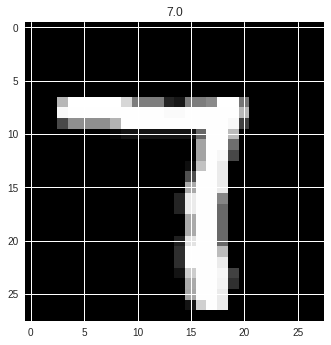

In [19]:
show_img(x_train[55], y_train[55])

In [0]:
def duplicate_channels(data):  
  print(data.shape)

  arr = data.reshape(data.shape[0], 784)
  print(arr.shape)
  
  return arr

#   arr = np.repeat(arr, 3, axis=1)
#   print(arr.shape)

#   to_recognize = arr.reshape(data.shape[0], 28, 28, 3)
#   print(to_recognize.shape)
  
#   return to_recognize

In [23]:
x_train = duplicate_channels(x_train)
x_valid = duplicate_channels(x_valid)

(48000, 28, 28)
(48000, 784)
(12000, 28, 28)
(12000, 784)


In [0]:
# class ResnetIdentityBlock(tf.keras.Model):
#   def __init__(self, kernel_size, filters):
#     super(ResnetIdentityBlock, self).__init__(name='')     
#     filters1, filters2, filters3 = filters
    
#     self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
#     self.bn2a = tf.keras.layers.BatchNormalization()
    
#     self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
#     self.bn2b = tf.keras.layers.BatchNormalization()
    
#     self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
#     self.bn2c = tf.keras.layers.BatchNormalization()
    
#   def call(self, input_tensor, training=False):
#     x = self.conv2a(input_tensor)
#     x = self.bn2a(x, training=training)
#     x = tf.nn.relu(x)
    
#     x = self.conv2b(x)
#     x = self.bn2b(x, training=training)
#     x = tf.nn.relu(x)
    
#     x = self.conv2c(x)
#     x = self.bn2c(x, training=training)
    
#     x += input_tensor
#     return tf.nn.relu(x)

In [0]:
# class ResnetIdentityModel(tf.keras.Model):
#   def __init__(self, layers, c):
#     super(ResnetIdentityModel, self).__init__(name='ResnetIdentityModel')
    
#     self.blocks = tf.keras.Sequential(
#         #[ ResnetIdentityBlock( [10, 10, 10], 5) for layer in layers ]
#         [ ResnetIdentityBlock( 5, [10, 10, 10] ) for x in range(7) ]
#     )
    
#     self.out = tf.keras.layers.Dense(c)
          
#   def call(self, input_tensor, training=False):
#     print(input_tensor.shape)
    
#     x = self.blocks(input_tensor)    
#     print(x.shape)
    
#     x = tf.keras.layers.GlobalMaxPool2D(x)
#     print(x.shape)
    
#     x = x.view(x.size(0), -1)            
#     print(x.shape)
        
#     x = self.out(x)
#     print(x.shape)
    
#     return tf.math.log_softmax(x, dim=-1)
    

In [0]:
# class ResnetLayer(tf.keras.layers.BatchNormalization):  
#   def call(self, x): return x + super().call(x)

In [0]:
# class Resnet(tf.keras.Model):
#     def __init__(self, layers, c):
#         super().__init__()                
                        
#         layers_num = range(len(layers) - 1)
        
#         self.conv1 = tf.keras.layers.Conv2D(filters=10, kernel_size=5, strides=1, padding='same')
                
#         self.layers1 = tf.keras.Sequential(
#             [tf.keras.layers.BatchNormalization(layers[i+1], layers[i + 1], 1) for i in range(layers_num)]            
#         )
        
#         self.layers2 = tf.keras.Sequential(
#             [ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(layers_num)]            
#         )
        
#         self.layers3 = tf.keras.Sequential(
#             [ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(layers_num)]            
#         )
        
#         self.out = tf.keras.layers.Dense(c)
        
#     def call(self, x, training=False):
#       print(x.shape)
#       x = self.conv1(x)
        
#       for l,l2,l3 in zip(self.layers1, self.layers2, self.layers3):
#         x = l3(l2(l(x)))
                
#         #x = F.adaptive_max_pool2d(x, 1) # jsut calculate the target and do just max pool . 1 x 1 x 10 (minibatch by num features)
#         #x = tf.keras.layers.GlobalMaxPool2D(data_format='channels_last', x) # needcheck where chennels are                
        
#         x = tf.keras.layers.GlobalMaxPool2D(x) # needcheck where chennels are                
        
# #         print(x.shape)
        
#         # here must be 10
#         x = x.view(x.size(0), -1)        
#         return tf.math.log_softmax(self.out(x), dim=-1)

In [0]:
#!pip install tensorboardcolab

In [0]:
#from tensorboardcolab import *

In [0]:
#tbc=TensorBoardColab()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=(28 * 28,) ),    
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Dense(10),    
    tf.keras.layers.Softmax()
])    
      

In [0]:
#model = Resnet([10, 20, 40, 80, 160], 10)
#model = ResnetIdentityModel(7, 10)

In [0]:
 # here I have to impl CLR
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)
#optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-3)

In [0]:
#def nll_loss(y_true, y_pred):
  

In [0]:
model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['accuracy'])

#nn.NLLLoss()

In [56]:
model.summary()
#tf.contrib.summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
re_lu (ReLU)                 (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [27]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((48000, 784), (48000,), (12000, 784), (12000,))

In [53]:
model.fit(x = x_train, y = y_train, epochs=3, verbose=1, validation_data=(x_valid, y_valid)
          #,callbacks=[TensorBoardColabCallback(tbc)]
         )

Epoch 1/10
1500/1500 [==============================] - 26s 17ms/step - loss: 2.5769 - acc: 0.0000e+00 - val_loss: 2.5633 - val_acc: 0.0000e+00
Epoch 2/10
1495/1500 [============================>.] - ETA: 0s - loss: 2.5775 - acc: 0.0000e+00

KeyboardInterrupt: ignored

In [55]:
i = 0
pred = x_valid[i][None, :]
print(y_valid[i])

#model.predict(pred)

model.predict_classes(pred)

6.0


array([8])

(784,)